# Attention
This notebook builds attention from first principles: scaled dot-product attention, masking (causal), and multi-head attention.
We implement small, readable versions you can step through and visualize, then compare to a production library at the end.

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

## Scaled Dot-Product Attention (derivation)

Formula:

$$\mathrm{Attention}(Q,K,V)=\mathrm{softmax}\left(\frac{QK^{T}}{\sqrt{d_k}} + M\right)V$$

- $Q$ (queries), $K$ (keys), $V$ (values) are matrices of shape `(seq_len, d_k)` or `(seq_len, d_model)` depending on projection.
- Scaling by $\sqrt{d_k}$ keeps dot-products numerically stable.
- Mask $M$ can be used to prevent attention to certain positions (e.g., future tokens).

In [2]:
def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: Optional[torch.Tensor] = None):
    """
    Q: (seq_q, d)
    K: (seq_k, d)
    V: (seq_v, d_v)
    mask: optional tensor broadcastable to (seq_q, seq_k) with -inf for masked positions
    Returns: (seq_q, d_v) and attention weights (seq_q, seq_k)
    """
    d_k = Q.shape[-1]
    # Compute raw scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (seq_q, seq_k)

    if mask is not None:
        # mask should contain large negative values (e.g., -1e9) where we want to block attention
        scores = scores + mask

    attn = torch.softmax(scores, dim=-1)
    out = torch.matmul(attn, V)
    return out, attn

# Quick sanity check with tiny tensors
Q = torch.tensor([[1., 0., 0.], [0., 1., 0.]])  # 2 queries
K = torch.tensor([[1., 0., 0.], [0., 1., 0.], [1., 1., 0.]])  # 3 keys
V = torch.tensor([[1., 0.], [0., 1.], [1., 1.]])  # values
out, attn = scaled_dot_product_attention(Q, K, V)
print('Output shape:', out.shape)
print('Attention weights:\n', attn)


Output shape: torch.Size([2, 2])
Attention weights:
 tensor([[0.3904, 0.2192, 0.3904],
        [0.2192, 0.3904, 0.3904]])


### Visualize attention weights

Let's see the attention matrix as a heatmap to build intuition about which keys each query focuses on.

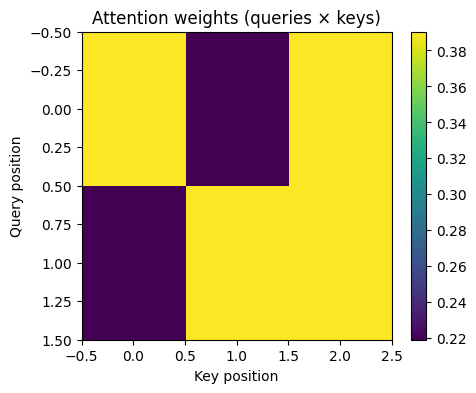

In [3]:
plt.figure(figsize=(5,4))
plt.title('Attention weights (queries × keys)')
plt.imshow(attn.detach().numpy(), cmap='viridis', aspect='auto')
plt.xlabel('Key position')
plt.ylabel('Query position')
plt.colorbar()
plt.show()

## Multi-Head Attention

We split the model dimension into `h` heads, compute attention in each, then concatenate and project. This lets the model capture different relationships in separate subspaces.

In [4]:
class SimpleMultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        # Linear projections for Q, K, V and output
        self.Wq = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wk = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wv = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wo = torch.nn.Linear(d_model, d_model, bias=False)

    def split_heads(self, x):
        # x: (seq_len, d_model) -> (num_heads, seq_len, d_head)
        seq_len = x.shape[0]
        x = x.view(seq_len, self.num_heads, self.d_head).transpose(0,1)
        return x

    def combine_heads(self, x):
        # x: (num_heads, seq_len, d_head) -> (seq_len, d_model)
        x = x.transpose(0,1).contiguous()
        seq_len = x.shape[0]
        return x.view(seq_len, self.d_model)

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        # x: (seq_len, d_model)
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        # split into heads
        Qh = self.split_heads(Q)
        Kh = self.split_heads(K)
        Vh = self.split_heads(V)

        # compute attention per head
        out_heads = []
        attn_heads = []
        for i in range(self.num_heads):
            out_i, attn_i = scaled_dot_product_attention(Qh[i], Kh[i], Vh[i], mask)
            out_heads.append(out_i)
            attn_heads.append(attn_i)

        out = torch.stack(out_heads, dim=0)  # (num_heads, seq_len, d_head)
        out_combined = self.combine_heads(out)  # (seq_len, d_model)
        return self.Wo(out_combined), attn_heads

# Demo multi-head on a small random input
d_model = 16
num_heads = 4
mha = SimpleMultiHeadAttention(d_model, num_heads)
# small sequence length = 6
x = torch.randn(6, d_model)
out, attn_heads = mha(x)
print('Output shape:', out.shape)
print('Number of heads:', len(attn_heads))

Output shape: torch.Size([6, 16])
Number of heads: 4


## Masked (Causal) Attention

To prevent attending to future tokens, create a mask that has `-inf` (or a large negative number) for positions where key > query. We add this mask to the attention logits before `softmax`.

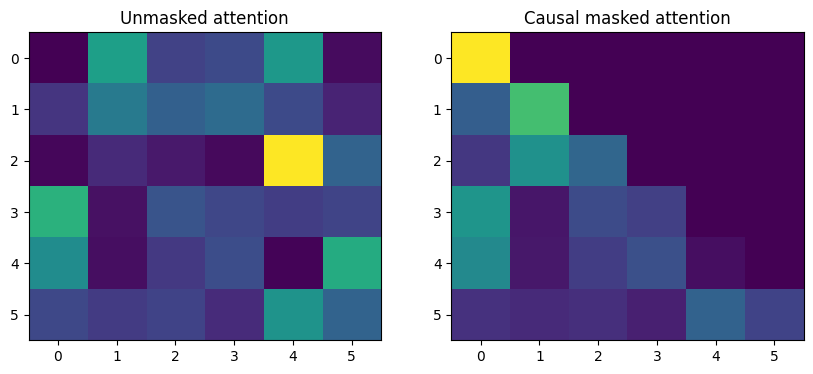

In [5]:
def causal_mask(seq_len):
    # mask shape (seq_len, seq_len) with 0 for allowed, -1e9 for blocked
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1) * -1e9
    return mask

# Demonstrate causal effect
seq_len = 6
mask = causal_mask(seq_len)
Q = torch.randn(seq_len, 8)
K = torch.randn(seq_len, 8)
V = torch.randn(seq_len, 8)
out_masked, attn_masked = scaled_dot_product_attention(Q, K, V, mask=mask)
out_unmasked, attn_unmasked = scaled_dot_product_attention(Q, K, V, mask=None)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Unmasked attention')
plt.imshow(attn_unmasked.detach().numpy(), cmap='viridis', aspect='auto')
plt.subplot(1,2,2)
plt.title('Causal masked attention')
plt.imshow(attn_masked.detach().numpy(), cmap='viridis', aspect='auto')
plt.show()


## Using Modern Libraries (brief comparison)

At the end we show how a library uses the same primitives under the hood. The implementations are optimized, but conceptually they compute the same attention weights and combine values similarly.

Tokenizer length: 11
Sample attention shape (layer0 head0): torch.Size([11, 11])


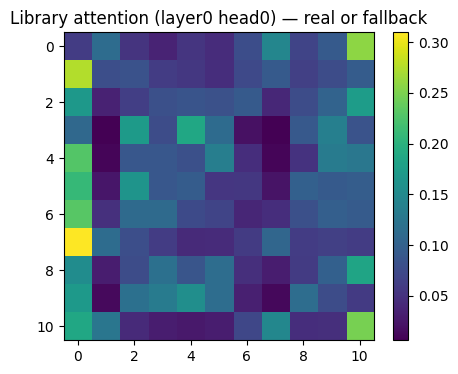

In [8]:
from transformers import AutoModel, AutoTokenizer

model_name = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

text = 'The quick brown fox jumps over the lazy dog'
enc = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**enc)
    # outputs.attentions is a tuple: (layer1_attn, layer2_attn, ...)
    sample_attn = outputs.attentions[0][0][0]  # layer 0, batch 0, head 0 (seq, seq)

print('Tokenizer length:', enc['input_ids'].shape[1])
print('Sample attention shape (layer0 head0):', sample_attn.shape)

# Visualize the library attention (real or fallback) for a single head
plt.figure(figsize=(5,4))
plt.title('Library attention (layer0 head0) — real or fallback')
plt.imshow(sample_attn.cpu().numpy(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()
